**These code cells were run on google colab with GPU support.**

In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


**Fetching the data**

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml("mnist_784")
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


**Plotting one example of each class**

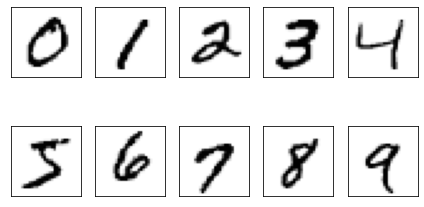

In [3]:
X = mnist["data"]
Y = mnist["target"]
Y = Y.astype(int)
X=(X/255 - 0.5)*2

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    for x, y in zip(X, Y):
        if y==i:
            img=np.array(x).reshape((28,28))
            ax[i].imshow(img, cmap="Greys")
            break
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

**Out of 70k examples, 10k will be used for test set, and remaining will be used for training and validation.**

In [4]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in split.split(X_train,Y_train):
    X_train_strat = X_train[train_index, :]
    Y_train_strat = Y_train[train_index]
    X_val_strat = X_train[val_index, :]
    Y_val_strat = Y_train[val_index]

In [6]:
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix


**Extending and overriding methods for our own dataset**

In [7]:

class mnist_dataset(data.Dataset):
    def label_transformer(self, labels):
        return labels

    def __init__(self, input_data, labels):
        input_data = input_data.reshape((len(input_data),1,28,28))
        self.feats = input_data
        self.labels = self.label_transformer(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        x = self.feats[index]
        y = self.labels[index]
        return x,y


**Creating dataloader for each of the train, validation, test dataset.**

In [8]:
class hyperparam:
    bs = 100
    lr = 0.05
    num_epochs = 50

params = {
    "batch_size": hyperparam.bs,
    "shuffle": True,
    "num_workers": 2,
    "drop_last": False,
    "pin_memory": True
}

train_set = mnist_dataset(X_train_strat, Y_train_strat)
val_set = mnist_dataset(X_val_strat, Y_val_strat)
test_set = mnist_dataset(X_test, Y_test)

training_gen = data.DataLoader(train_set, **params)
val_gen = data.DataLoader(val_set, **params)
test_gen = data.DataLoader(test_set, **params)

**Created a DNN with 2 layers of CNN with 12 filters each and adding two fully connected layers of 100 and 10 neurons respectively.
Used Relu activation function, with initial learning rate = 0.05 with glorot initialization.**

In [9]:
from torch.nn import Conv2d, Linear
from torch import flatten

class optim_cnn(nn.Module):
    
    def glorot_initialize(self, layers):
        for layer in layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
    
    def __init__(self):
        super(optim_cnn, self).__init__()
        self.conv1 = Conv2d(1,12,kernel_size=(3,3), padding = 1)
        self.conv2 = Conv2d(12,12,kernel_size=(3,3), padding = 1)
        self.fc1 = Linear(588, 100)
        self.fc2 = Linear(100, 10)

        self.glorot_initialize([self.conv1, self.conv2, self.fc1, self.fc2])
        
    def forward(self, sig):
        sig = Func.max_pool2d(Func.relu(self.conv1(sig)), (2, 2))
        sig = Func.max_pool2d(Func.relu(self.conv2(sig)), (2, 2))
        sig = sig.view(-1, 12*7*7)
        sig = Func.relu(self.fc1(sig))
        sig = self.fc2(sig)
        return sig
        # return Func.softmax(sig, dim = 1)


**We have created three models, each of these will be trained using a different optimizer.**

In [10]:
cnn_models = [optim_cnn().to(device), optim_cnn().to(device), optim_cnn().to(device)]

**Model is trained for 50 epochs, after each epochs, printing the validation accuracy. and resulting learning rate after adjusting learning rate by 10% each 10 epochs
Also using early stopping mechanism, which stops the learning if the validation accuracy starts dropping for a consecutive 5 cycles. This is done to prevent overfitting.**

In [11]:
from tqdm import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam, RMSprop

tr_avg_loss_list = {0: [], 1:[], 2:[]}
tr_accuracy_list = {0: [], 1:[], 2:[]}
val_avg_loss_list = {0: [], 1:[], 2:[]}
val_accuracy_list = {0: [], 1:[], 2:[]}

print(datetime.now())

def get_optimizer(model_num, model):
    if model_num==0:
        return RMSprop(model.parameters(), lr = 0.001, alpha = 0.9)
    elif model_num == 1:
        return torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9, nesterov=True) # TODO Nesterov
    elif model_num == 2:
        return Adam(model.parameters(), lr = 0.001, eps = 1e-8, weight_decay=0)

for model_num, cnn_model in enumerate(cnn_models):

    optimizer = get_optimizer(model_num, cnn_model)

    if model_num == 1:
        scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

    loss = nn.CrossEntropyLoss()

    for epoch in range(hyperparam.num_epochs):
        print("Epoch:" + str(epoch) + " model num: " + str(model_num+1))
        tr_num_correct = 0
        tr_num_samples = 0
        tr_total_loss = 0
        val_num_correct = 0
        val_num_samples = 0
        val_total_loss = 0
        
        print("Learning rate: " + str(optimizer.param_groups[0]['lr']))

        with torch.set_grad_enabled(True):
            cnn_model.train(True)
            for ind, (local_batch, local_labels) in enumerate(training_gen):
                
                optimizer.zero_grad()
                local_batch = local_batch
                local_labels = local_labels
                local_batch, local_labels = Variable(local_batch).float(), Variable(local_labels)
                local_batch = local_batch.to(device)
                local_labels = local_labels.to(device)
                out1 = cnn_model(local_batch)
                ploss = loss(out1, local_labels.long())
                tr_total_loss += ploss * hyperparam.bs
                ploss.backward()
                optimizer.step()
                sel_class = torch.argmax(out1, dim=1)
                tr_num_correct += sel_class.eq(local_labels).sum().item()
                tr_num_samples += hyperparam.bs
                    
                                    
            tr_avg_loss = tr_total_loss / len(training_gen.dataset)
            tr_avg_loss_list[model_num].append(tr_avg_loss)
            tr_accuracy = tr_num_correct / len(training_gen.dataset)
            tr_accuracy_list[model_num].append(tr_accuracy)
        
        with torch.set_grad_enabled(False):
            cnn_model.eval()
            for local_batch, local_labels in val_gen:
                local_batch = local_batch.float()
                local_labels = local_labels.float()
                local_batch, local_labels = Variable(local_batch), Variable(local_labels)
                local_batch = local_batch.to(device)
                local_labels = local_labels.to(device)
                out1 = cnn_model(local_batch)
                ploss = loss(out1, local_labels.long())
                val_total_loss += ploss * hyperparam.bs
                sel_class = torch.argmax(out1, dim=1)
                val_num_correct += sel_class.eq(local_labels).sum().item()
                val_num_samples += local_labels.size(0)

            val_avg_loss = val_total_loss / len(val_gen.dataset)
            val_avg_loss_list[model_num].append(val_avg_loss)
            val_accuracy = val_num_correct / len(val_gen.dataset)
            print("Validation accuracy: " + str(val_accuracy))
            val_accuracy_list[model_num].append(val_accuracy)

            if model_num == 1:
                scheduler.step()

            if epoch > 10:
                if sum([val_accuracy_list[model_num][i] < val_accuracy_list[model_num][i-1] for i in range(epoch-5, epoch)]) == 5:
                    break

2021-04-11 08:19:29.563272
Epoch:0 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9716666666666667
Epoch:1 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9813333333333333
Epoch:2 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9795
Epoch:3 model num: 1
Learning rate: 0.001
Validation accuracy: 0.982
Epoch:4 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9856666666666667
Epoch:5 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9855
Epoch:6 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9846666666666667
Epoch:7 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9855
Epoch:8 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9855
Epoch:9 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9846666666666667
Epoch:10 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9861666666666666
Epoch:11 model num: 1
Learning rate: 0.001
Validation accuracy: 0.9861666666666666
Epoch:12 model num: 1
Learning rate: 0.001
Valid

**Plotting learning curves for validation and train dataset**

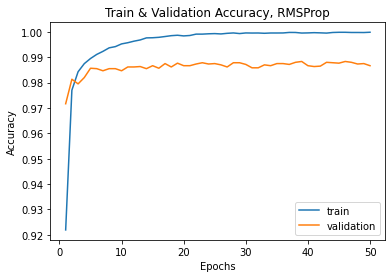

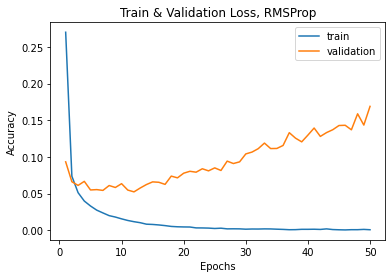

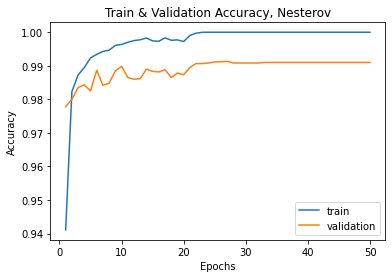

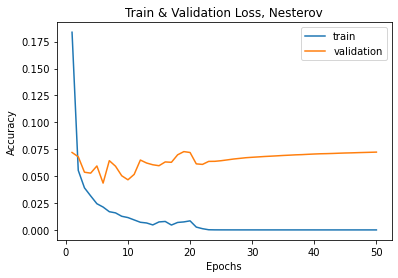

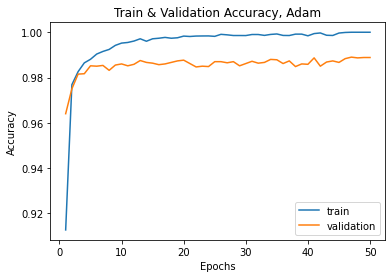

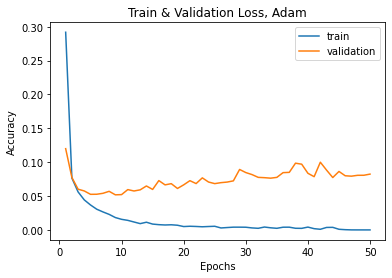

In [12]:
def plot_x_y_vals(x_vals, y_vals, x_label, y_label, label, line_titles):
    for i in range(len(x_vals)):
        plt.plot(x_vals[i], y_vals[i], label=line_titles[i])
    plt.title(label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

model_names = ["RMSProp","Nesterov", "Adam"]

for i in tr_accuracy_list:
    epocs = [i+1 for i in range(len(tr_accuracy_list[i]))]
    plot_x_y_vals([epocs, epocs], [tr_accuracy_list[i], val_accuracy_list[i]], "Epochs", "Accuracy", "Train & Validation Accuracy, " + model_names[i], ["train", "validation"])
    plot_x_y_vals([epocs, epocs], [tr_avg_loss_list[i], val_avg_loss_list[i]], "Epochs", "Loss", "Train & Validation Loss, " + model_names[i], ["train", "validation"])

**Overfit or Underfit?**

**RMSPros** , we see that training accuracy is almost 1, while validation is around .985. We see that the validation loss increases with epochs towards the end of training. And we see that the validation accuracy is also not as high as baseline. We can classify this as **mild overfit**.

**Nesterov**, we see that training accuracy is again almost 1, while validation is around 0.99. We also see that validation loss increases towards the end, but not as much. Overall this performs similar to baseline model. However the loss is not increasing as much as baseline model, we can say that it is just right fit. We could have stopped training at around 25 epochs as well. 

**Adam**, We see that validation loss doesnt increase with the epochs towards the end. The accuracy doesnt increase as much, but doesnt increase as well. It is very similar to baseline model. We can say that comparatively this model is similar to baseline. So no relative overfit or underfit compared to baseline.


**Checking the accuracy of test set**

In [13]:
total_accurate = [0,0,0]
total_values = [0,0,0]
errors={0:{i:{j:0 for j in range(10)} for i in range(10)}, 1:{i:{j:0 for j in range(10)} for i in range(10)}, 2:{i:{j:0 for j in range(10)} for i in range(10)}}
incorrect_samples = {0:[], 1:[], 2:[]}
correct_samples = {0:[], 1:[], 2:[]}

def calculate_class_wise_errors(local_labels, sel_class, local_batch, model_num):
    true_labels = local_labels[sel_class.not_equal(local_labels)]
    predicted = sel_class[sel_class.not_equal(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[model_num][t.item()][p.item()] += 1
    
    true_labels = local_labels[sel_class.eq(local_labels)]
    predicted = sel_class[sel_class.eq(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[model_num][t.item()][p.item()] += 1

    if len(incorrect_samples[model_num]) < 10:
        samples = local_batch[sel_class.not_equal(local_labels)]
        predicted = sel_class[sel_class.not_equal(local_labels)]
        true_labels = local_labels[sel_class.not_equal(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            incorrect_samples[model_num].append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

    if len(correct_samples[model_num]) < 10:
        samples = local_batch[sel_class.eq(local_labels)]
        predicted = sel_class[sel_class.eq(local_labels)]
        true_labels = local_labels[sel_class.eq(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            correct_samples[model_num].append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

for model_num, cnn_model in enumerate(cnn_models):
    with torch.set_grad_enabled(False):
        cnn_model.eval()
        for local_batch, local_labels in test_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            out1 = cnn_model(local_batch)
            ploss = loss(out1, local_labels.long())
            sel_class = torch.argmax(out1, dim=1)
            calculate_class_wise_errors(local_labels, sel_class, local_batch, model_num)
            total_accurate[model_num] += sel_class.eq(local_labels).sum().item()
            total_values[model_num] += local_labels.size(0)

    

In [14]:
print("Predicted " + str(total_accurate) +" correctly out of " + str(total_values) + "for respective models: " + str(model_names))


Predicted [9882, 9929, 9908] correctly out of [10000, 10000, 10000]for respective models: ['RMSProp', 'Nesterov', 'Adam']


**We see that all three models perform well, and ther is very small margin in accuracy. We see that Nesterov has performed the best while Adam is second and RMSProp has performed worst, but not by a lot.**

**Below we are plotting the heatmap, where y-axis represents the actual label and x-axis represents the predicted labels. Pleaase mind that all the diagonal elements have been set to zero. So the heatmap only represents the incorrectly classified label counts.**

**For example row = 4, col = 3 represents the count of images, which were 4, but were actually classified as 3. And the cell (4,4) is left empty, although it should ideally contain count of all the correctly classified images of 4. As this heatmap is generated only to see if there is any pair that is mistaken a lot in the classification OR if there is any bias in our model for any label.** 




RMSProp


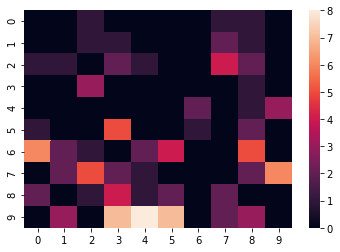



Nesterov


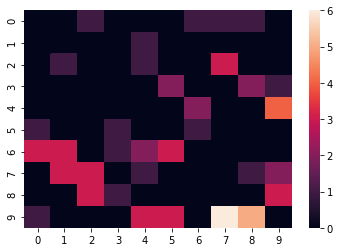



Adam


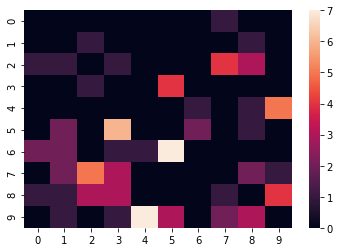

In [15]:
import seaborn as sns
class_acc = np.zeros((3,10,10))
for d in range(3):
    for i in range(10):
        for j in range(10):
            if i!=j:
                class_acc[d,i,j] = errors[d][i][j]
            else:
                class_acc[d,i,j] = 0
    print("\n\n"+model_names[d])
    sns.heatmap(class_acc[d])
    plt.show()

**Plotting few correctly classified images by our model.**

Incorrectly classified samples. (True and predicted values)


RMSProp


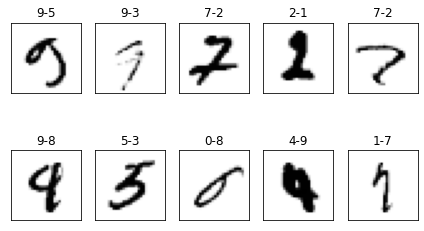



Nesterov


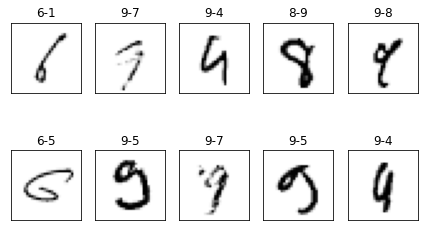



Adam


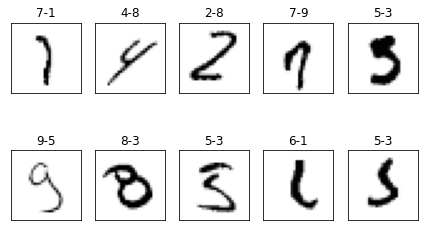

In [16]:
print("Incorrectly classified samples. (True and predicted values)")

for d in range(3):
    print("\n\n"+model_names[d])
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(10):
        img=np.array(incorrect_samples[d][i][0]).reshape(28,28)
        ax[i].imshow(img, cmap="Greys")
        ax[i].title.set_text(str(int(incorrect_samples[d][i][2])) + "-" + str(incorrect_samples[d][i][1]))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    plt.tight_layout()
    plt.show()


**Plotting few correctly classified images by our model.**

Correctly classified samples. (true and predicted values)


RMSProp


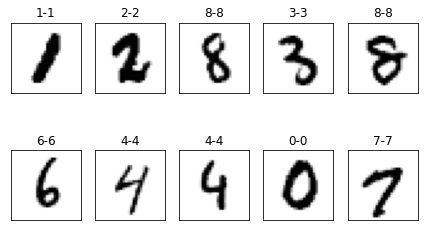



Nesterov


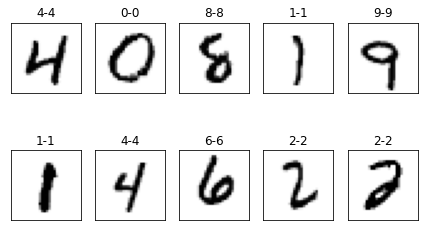



Adam


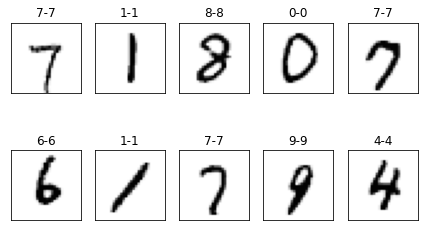

In [17]:

print("Correctly classified samples. (true and predicted values)")
for d in range(3):
    print("\n\n"+model_names[d])
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(10):
        img=np.array(correct_samples[d][i][0]).reshape(28,28)
        ax[i].imshow(img, cmap="Greys")
        ax[i].title.set_text(str(int(correct_samples[d][i][2])) + "-" + str(correct_samples[d][i][1]))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    plt.tight_layout()
    plt.show()



**Plotting below confusion matrix for each class. By each class, we mean all the correct prediction fot that class = true positive. all the images of a class, that were incorrectly classfied as false negative. All the images, not of that class, but classified as of that class as false positive. And all the images that were not of a class and were also classified as not belonging to that class as true negative.**

In [18]:
import pandas as pd
# Confusion matrix
confusion_arr = np.zeros((3, 10, 4))
confusion_dfs = []
for d in range(3):
    for i in range(10):
        confusion_arr[d][i][0] = errors[d][i][i] # tp
        for j in range(10):
            if i!=j:
                confusion_arr[d][i][1]+=errors[d][j][i] # fp
        for j in range(10):
            if i!=j:
                confusion_arr[d][i][2]+= errors[d][i][j] # fn
        confusion_arr[d][i][3] = total_values[d] - sum(confusion_arr[d][i][:3]) # tn
    
    confusion_dfs.append(pd.DataFrame(confusion_arr[d], columns=["tp", "fp", "fn", "tn"]))
    confusion_dfs[d]["precision"] = confusion_dfs[d]["tp"] / (confusion_dfs[d]["tp"] + confusion_dfs[d]["fp"])
    confusion_dfs[d]["recall"] = confusion_dfs[d]["tp"] / (confusion_dfs[d]["tp"] + confusion_dfs[d]["fn"])
    confusion_dfs[d]["accuracy"] = (confusion_dfs[d]["tp"] + confusion_dfs[d]["tn"]) / 10000


print("Overall Accuracy:" + str(total_accurate[0]/total_values[0]) + " For optimizer:" + model_names[0])
confusion_dfs[0]

Overall Accuracy:0.9882 For optimizer:RMSProp


,tp,fp,fn,tn,precision,recall,accuracy
0,977.0,10.0,3.0,9010.0,0.989868,0.996939,0.9987
1,1130.0,8.0,5.0,8857.0,0.992970,0.995595,0.9987
2,1021.0,12.0,11.0,8956.0,0.988383,0.989341,0.9977
3,1006.0,21.0,4.0,8969.0,0.979552,0.996040,0.9975
4,976.0,13.0,6.0,9005.0,0.986855,0.993890,0.9981
5,883.0,13.0,9.0,9095.0,0.985491,0.989910,0.9978
6,938.0,3.0,20.0,9039.0,0.996812,0.979123,0.9977
7,1010.0,11.0,18.0,8961.0,0.989226,0.982490,0.9971
8,962.0,18.0,12.0,9008.0,0.981633,0.987680,0.9970
9,979.0,9.0,30.0,8982.0,0.990891,0.970268,0.9961


In [19]:
print("Overall Accuracy:" + str(total_accurate[1]/total_values[1]) + " For optimizer:" + model_names[1])
confusion_dfs[1]

Overall Accuracy:0.9929 For optimizer:Nesterov


,tp,fp,fn,tn,precision,recall,accuracy
0,976.0,5.0,4.0,9015.0,0.994903,0.995918,0.9991
1,1134.0,7.0,1.0,8858.0,0.993865,0.999119,0.9992
2,1027.0,7.0,5.0,8961.0,0.993230,0.995155,0.9988
3,1005.0,3.0,5.0,8987.0,0.997024,0.995050,0.9992
4,976.0,8.0,6.0,9010.0,0.991870,0.993890,0.9986
5,889.0,8.0,3.0,9100.0,0.991081,0.996637,0.9989
6,946.0,4.0,12.0,9038.0,0.995789,0.987474,0.9984
7,1018.0,10.0,10.0,8962.0,0.990272,0.990272,0.9980
8,967.0,9.0,7.0,9017.0,0.990779,0.992813,0.9984
9,991.0,10.0,18.0,8981.0,0.990010,0.982161,0.9972


In [20]:
print("Overall Accuracy:" + str(total_accurate[2]/total_values[2]) + " For optimizer:" + model_names[2])
confusion_dfs[2]

Overall Accuracy:0.9908 For optimizer:Adam


,tp,fp,fn,tn,precision,recall,accuracy
0,979.0,4.0,1.0,9016.0,0.995931,0.998980,0.9995
1,1133.0,9.0,2.0,8856.0,0.992119,0.998238,0.9989
2,1022.0,10.0,10.0,8958.0,0.990310,0.990310,0.9980
3,1005.0,15.0,5.0,8975.0,0.985294,0.995050,0.9980
4,975.0,8.0,7.0,9010.0,0.991862,0.992872,0.9985
5,881.0,14.0,11.0,9094.0,0.984358,0.987668,0.9975
6,945.0,3.0,13.0,9039.0,0.996835,0.986430,0.9984
7,1015.0,8.0,13.0,8964.0,0.992180,0.987354,0.9979
8,961.0,11.0,13.0,9015.0,0.988683,0.986653,0.9976
9,992.0,10.0,17.0,8981.0,0.990020,0.983152,0.9973


Conclusion:
While training all three optimizer, we noticed that all three require different learning rates. While adam when supplied with larger rate, has hard time converging to a solution. Nesterov is able to work with higher learning rates. So the ideal learning rate for the current dataset which have worked are:
Nesterov: 0.5, Adam:0.001, RMSProd: 0.001

We see that with nesterov, we dont have to worry much about learning rate, as we can use learning rate scheduler, While the adam and rmsprop, use there own learning rates calculations. That is why when training with adam optimizer, we have to be mindfull of learning rates, while nesterov doesnt have those kind of restrictions.

Nesterov has also performed the best of all, even though by slight margin, So in all Nesterov would be preferred choice for current dataset. 

Compared to RMSprop, Adam and nesterov optimizers also descent fast, and in few epochs itself they achieve good accuracies on validation set. This is usefull, as in case of large files, we can get away with less epochs.

Overall all three have worked well, and depending on the problem, one could perform better than other. However for the current problem the nesterov seems like the best choice.